# problem4

In [46]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

np.random.seed(777)

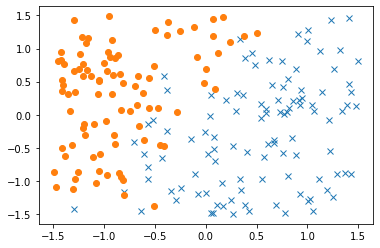

In [47]:
# dataset 4
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1

plt.plot(np.extract(y_d4==1,x_d4[:,0]),np.extract(y_d4==1,x_d4[:,1]), 'x')
plt.plot(np.extract(y_d4==-1,x_d4[:,0]),np.extract(y_d4==-1,x_d4[:,1]), 'o')

convex optimization

In [48]:
lam = 0.01
X = x_d4[:, :2]
Y = np.diag(y_d4)

w_cvx = cv.Variable((2,1))
xi_cvx = cv.Variable((n,1))
e_cvx = cv.Variable((2,1))
obj_fn = cv.sum(xi_cvx) +  lam * cv.sum(e_cvx)
objective = cv.Minimize(obj_fn)
constraints = [-1 * xi_cvx <= 0,
               -1 * Y @ X @ w_cvx - xi_cvx <= -1 * np.ones((n,1)),
               -1 * e_cvx <= 0,
               -1 * w_cvx - e_cvx <= 0,
               w_cvx - e_cvx <= 0]
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT)
w_cvx = w_cvx.value

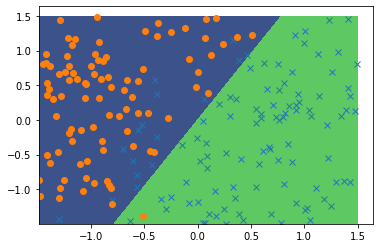

In [49]:
# plot boundary for binary classification

def plot_bi (x1, x2, y, w):
    delta = 0.01
    xa = np.arange(np.min(x1), np.max(x1), delta)
    ya = np.arange(np.min(x2), np.max(x2), delta)
    xm, ym = np.meshgrid(xa, ya)

    z = xm * w[0] + ym * w[1]

    plt.plot(np.extract(y==1,x1),np.extract(y==1,x2), 'x')
    plt.plot(np.extract(y==-1,x1),np.extract(y==-1,x2), 'o')

    plt.contourf(xm, ym, z, 0)


plot_bi(x_d4[:,0], x_d4[:,1], y_d4, w_cvx)

proximal sub-gradient method

In [50]:
eta = 0.5

def st_ops(mu, q):
    x_proj = np.zeros(mu.shape)
    for i in range(len(mu)):
        if mu[i] > q:
            x_proj[i] = mu[i] - q
        else:
            if np.abs(mu[i]) < q:
                x_proj[i] = 0
            else:
                x_proj[i] = mu[i] + q
    return x_proj

def hinge_grad (x, y, w):
    ywx = (x @ w) * y
    sub_grad = np.zeros(x.shape)
    for i in range(len(ywx)):
        if ywx[i] < 1:
            sub_grad[i,:] = -1 * y[i] * x[i, :]
        elif ywx[i] == 1:
            sub_grad[i,:] = -1 * eta * y[i] * x[i, :]
        else:
            sub_grad[i,:] = 0
    sub_grad = np.sum(sub_grad, axis=0)
    return sub_grad

In [51]:
num_iter = 100
X = x_d4[:, :2]
y = y_d4
wt = np.random.randn(2,)
#L = 30 * np.max(X[:,0]**2)
L = np.max(np.linalg.eig(X.T @ X)[0])

wt_history = []
for t in range(num_iter):
    wt_history.append(wt)
    grad = hinge_grad(X, y, wt)
    wt1 = wt - 1/L * grad
    wt = st_ops(wt1, lam/L)
wt_history = np.vstack(wt_history)
w_pro = wt

Text(0, 0.5, 'w1')

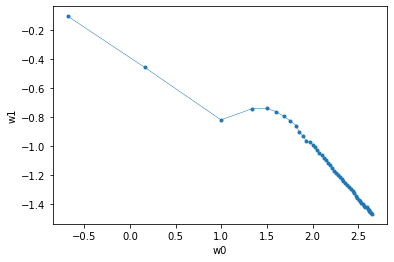

In [52]:
show_iter = 50

plt.plot(wt_history[:show_iter,0], wt_history[:show_iter,1], 'o-', markersize=3, linewidth=0.5)

plt.xlabel('w0')
plt.ylabel('w1')

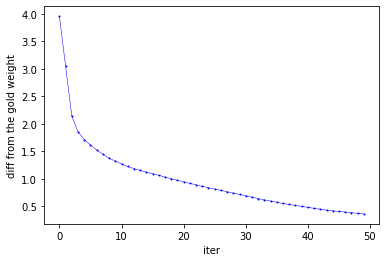

In [53]:
show_iter = 50

fig = plt.figure()

plt.plot(np.linalg.norm(wt_history[:show_iter] - w_cvx.reshape(1,2), axis=1), 'bo-', linewidth=0.5, markersize=1,)

plt.xlabel('iter')
plt.ylabel('diff from the gold weight')

fig.savefig("fig/proximal_subgrad.png")

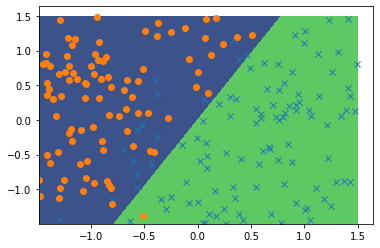

In [54]:
plot_bi(x_d4[:,0], x_d4[:,1], y_d4, w_pro)